## SR


In [1]:
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
device='cuda'

In [2]:
import base64
import io
def sr_to_pil(sr_tensor):
    """sr_tensor: [3,H,W] or [B,3,H,W] float in [-1,1] returns: PIL Image (RGB)"""
    if sr_tensor.dim() == 4:
        sr_tensor = sr_tensor[0] # first in batch
    sr_tensor = ((sr_tensor.clamp(-1, 1) + 1) * 127.5).to(torch.uint8)
    sr_np = sr_tensor.permute(1,2,0).cpu().numpy()
    return Image.fromarray(sr_np)

def pil_to_data_url(pil_img):
    buffered = io.BytesIO()
    pil_img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def html_for_images(pil_images, min_height=64, title="Hi"):
    data_urls = [pil_to_data_url(img) for img in pil_images]
    html = f"""
    <h2>{title}</h2>
    <div style="display: flex; flex-wrap: wrap; gap: 2px;">
    """
    for url in data_urls:
        html += f"""
        <div style="flex: 0 0 auto;">
            <img src="{url}" style="min-width: {min_height}px;"/>
        </div>
        """
    html += "</div>"
    return html

In [3]:
# EDM noise schedule, loss weighting, and sampling procedure
# EDM parameters from NVIDIA's reference
P_mean = -1.2  # Mean of log-normal distribution for sigma sampling
P_std = 1.2    # Std of log-normal distribution for sigma sampling
sigma_data = 0.5  # Data standard deviation
sigma_min = 0.002
sigma_max = 80
rho = 7

# EDM noise schedule (sampling)
def edm_sigma_schedule(t):
    return (sigma_max ** (1/rho) + t * (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho

# EDM loss weighting - CORRECTED according to NVIDIA's implementation
# weight = (σ² + σ_data²) / (σ × σ_data)²
def edm_loss_weight(sigma, sigma_data=sigma_data):
    return (sigma ** 2 + sigma_data ** 2) / (sigma * sigma_data) ** 2


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

# --- Helper: sinusoidal timestep embedding ---
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):  # t: [B] in [0,1] float
        device = t.device
        half_dim = self.dim // 2
        freqs = torch.exp(
            torch.arange(half_dim, device=device) * -(math.log(10000) / (half_dim - 1)) 
        )
        emb = t[:, None] * freqs[None, :]   # [B, half_dim]
        emb = torch.cat([emb.sin(), emb.cos()], dim=-1)  # [B, dim]
        return emb

# --- Basic residual block ---
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        self.block1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.block2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        # x: [B, C, H, W], t_emb: [B, time_emb_dim]
        h = F.silu(self.block1(x))
        # Add time embedding as bias
        h += self.time_mlp(t_emb)[:, :, None, None]
        h = F.silu(self.block2(h))
        return h + self.res_conv(x)

# --- U-Net core ---
class UNetSR3(nn.Module):
    def __init__(self, in_ch=6, out_ch=3, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_emb = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Encoder
        self.enc1 = ResBlock(in_ch, base_ch, time_emb_dim)
        self.enc2 = ResBlock(base_ch, base_ch * 2, time_emb_dim)
        self.enc3 = ResBlock(base_ch * 2, base_ch * 4, time_emb_dim)

        # Bottleneck
        self.mid = ResBlock(base_ch * 4, base_ch * 4, time_emb_dim)

        # Decoder
        self.dec3 = ResBlock(base_ch * 4 + base_ch * 4, base_ch * 2, time_emb_dim)
        self.dec2 = ResBlock(base_ch * 2 + base_ch * 2, base_ch, time_emb_dim)
        self.dec1 = ResBlock(base_ch + base_ch, base_ch, time_emb_dim)

        # Final output: predict noise (same shape as HR image)
        self.out_conv = nn.Conv2d(base_ch, out_ch, 1)

        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        """
        x: [B, 6, 256, 256] = concat([x_noisy, lr_upsampled])
        t: [B] float timesteps normalized to [0,1]
        """
        # ---- time embedding ----
        t_emb = self.time_emb(t)  # [B, time_emb_dim]

        # ---- down path ----
        e1 = self.enc1(x, t_emb)           # [B, 64, 256, 256]
        e2 = self.enc2(self.down(e1), t_emb)  # [B, 128, 128, 128]
        e3 = self.enc3(self.down(e2), t_emb)  # [B, 256, 64, 64]

        # ---- bottleneck ----
        m = self.mid(e3, t_emb)             # [B, 256, 64, 64]

        # ---- up path ----
        #d3 = self.dec3(torch.cat([self.up(m), e3], dim=1), t_emb)  # [B, 128, 64, 64]
        #d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1), t_emb) # [B, 64, 128, 128]
        #d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1), t_emb) # [B, 64, 256, 256]
        # ---- up path (fixed spatial alignment) ----
        d3 = self.dec3(torch.cat([m, e3], dim=1), t_emb)            # [B, 128, 64, 64]
        d3_up = self.up(d3)                                         # [B, 128, 128, 128]

        d2 = self.dec2(torch.cat([d3_up, e2], dim=1), t_emb)         # [B, 64, 128, 128]
        d2_up = self.up(d2)                                         # [B, 64, 256, 256]

        d1 = self.dec1(torch.cat([d2_up, e1], dim=1), t_emb)         # [B, 64, 256, 256]

        return self.out_conv(d1)  # [B, 3, 256, 256]


In [5]:
# Sanity check the model's inpus and outputs are as expected
B = 4
hrimg = torch.randn(B, 3, 256, 256).cuda()
lrimg = torch.randn(B, 3, 64, 64).cuda()
t = torch.rand(B).cuda()

lr_up = F.interpolate(lrimg, size=(256,256), mode='bilinear', align_corners=False)
x_noisy = torch.randn_like(hrimg)
x_in = torch.cat([x_noisy, lr_up], dim=1).cuda()

model = UNetSR3().cuda()
with torch.no_grad():
    out = model(x_in, t)
print("Output:", out.shape)  # should be [4, 3, 256, 256]
num_params = sum(p.numel() for p in model.parameters())
print(f"SRUNet number of parameters: {num_params:,}")

Output: torch.Size([4, 3, 256, 256])
SRUNet number of parameters: 3,747,907


In [6]:
# TODO - re-merge with the one above
def edm_ancestral_sampling(model, lr_up, num_steps=18, batch_size=8, img_shape=(1, 28, 28),
                           headstart_sigma:float|None=None):
    """
        EDM ancestral sampling with optional noisy-LR head-start.
        
        Args:
            model: UNet denoiser
            lr_up: upscaled LR image [B, 3, H, W]
            num_steps: number of sampling steps
            batch_size: batch size
            img_shape: shape of output images
            headstart_sigma: float or None
                If None, start from pure noise.
                If float, adds Gaussian noise with this std to lr_up for head-start.
    """
    device = next(model.parameters()).device
    
    # Initialize noise
    # ------------------- Head-start initialization -------------------
    if headstart_sigma is None:
        # Original behavior: pure Gaussian noise
        x_next = torch.randn((batch_size,) + img_shape, device=device)
    else:
        # Start from LR upsample + moderate noise
        lr_up_resized = F.interpolate(lr_up, size=img_shape[-2:], mode='bilinear', align_corners=False)
        x_next = lr_up_resized.to(device) + headstart_sigma * torch.randn((batch_size,) + img_shape, device=device)
    # ------------------------------------------------------------------

    
    # Time step schedule (matching NVIDIA's implementation)
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
    t_steps = (sigma_max ** (1/rho) + step_indices / (num_steps - 1) * 
               (sigma_min ** (1/rho) - sigma_max ** (1/rho))) ** rho
    t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
    
    # Initialize with first noise level
    x_next = x_next * t_steps[0]
    #-----------------------------------------------------
    # after head-start initialization
    if headstart_sigma is not None:
        """
        https://chatgpt.com/share/68c6111a-55d0-800b-b1b3-14e3cf3ff731
        Some papers also rescale the remaining t_steps proportionally to account for the lower starting noise, so the schedule adapts dynamically. But the simplest correct approach is just to replace the first t_steps[0] with the actual headstart_sigma.
        """
        t_steps[0] = headstart_sigma
    #-----------------------------------------------------
    # Main sampling loop (Heun's method)
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
        x_cur = x_next
        
        # Preconditioning coefficients for current timestep
        sigma = t_cur.float()
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Euler step
        this_models_input = torch.cat([c_in*x_cur, lr_up], dim=1).cuda()
        #F_x = model(c_in * x_cur, c_noise.expand(batch_size))
        F_x = model(this_models_input, c_noise.expand(batch_size))
        denoised = c_skip * x_cur + c_out * F_x
        d_cur = (x_cur - denoised) / t_cur
        x_next = x_cur + (t_next - t_cur) * d_cur
        
        # Apply 2nd order correction (Heun's method) - except for last step
        if i < num_steps - 1:
            # Preconditioning coefficients for next timestep
            sigma_next = t_next.float()
            c_skip_next = sigma_data ** 2 / (sigma_next ** 2 + sigma_data ** 2)
            c_out_next = sigma_next * sigma_data / (sigma_next ** 2 + sigma_data ** 2).sqrt()
            c_in_next = 1 / (sigma_data ** 2 + sigma_next ** 2).sqrt()
            c_noise_next = sigma_next.log() / 4
            
            #F_x_next = model(c_in_next * x_next, c_noise_next.expand(batch_size))
            this_models_input = torch.cat([c_in_next * x_next, lr_up], dim=1).cuda()
            F_x_next = model(this_models_input, c_noise_next.expand(batch_size))


            denoised_next = c_skip_next * x_next + c_out_next * F_x_next
            d_prime = (x_next - denoised_next) / t_next
            x_next = x_cur + (t_next - t_cur) * (0.5 * d_cur + 0.5 * d_prime)
    
    return x_next.to("cpu")

In [7]:
# sanity check shapes
with torch.no_grad():
    edm_ancestral_sampling(model,lr_up,batch_size=4,img_shape=(3,256,256))

In [8]:
# Modified from my diffusion model in a cell above.

from torch.amp.grad_scaler import GradScaler
scaler = GradScaler(device="cuda")
#from torch.cuda.amp import autocast
from torch.amp.autocast_mode import autocast
def train_a_batch(model_edm, optimizer_edm, batch):
 
        x = batch
        hr_256, lr_64 = x
        # Move to device
        hr_256 = hr_256.to(device)          # [B, 3, 256, 256]
        lr_64 = lr_64.to(device)            # [B, 3, 64, 64]

        x = hr_256
        # Log-normal sigma sampling (as in NVIDIA's implementation)
        rnd_normal = torch.randn([x.shape[0], 1, 1, 1], device=device)
        sigma = (rnd_normal * P_std + P_mean).exp()
        
        # Preconditioning coefficients (from NVIDIA's EDMPrecond)
        c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
        c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2).sqrt()
        c_in = 1 / (sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4
        
        # Add noise: y_noisy = x + σ·n where n ~ N(0,I)
        noise = torch.randn_like(x) * sigma
        y_noisy = x + noise
        
        # Model prediction: F_x = net(c_in * y_noisy, c_noise)
        c_noise_input = c_noise.view(x.shape[0])


        # Upsample LR to HR resolution
        lr_up = F.interpolate(lr_64, size=hr_256.shape[-2:], mode='bilinear', align_corners=False)
        # Expected shape: [B, 3, 256, 256]

        ## Sample timestep t for each item in batch
        #b = hr_256.shape[0]
        
        # Concatenate noisy HR + upsampled LR for conditioning
        x_input = torch.cat([y_noisy, lr_up], dim=1)  # [B, 6, 256, 256]

        # --- Optional sanity assertions ---
        assert x_input.shape[1] == 6, f"Expected 6 channels, got {x_input.shape[1]}"
        assert hr_256.shape == noise.shape, "HR and noise shapes must match"


        # this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1).cuda()
        # From ChatGPT code review
        # this_models_input = torch.cat([c_in * y_noisy, c_in * lr_up], dim=1).cuda()
        # TODO: I'm not sure I trust that -- it looked pretty good before this change.
        # but then in a second chatgpt code review it asked me to reverse it again
        # https://chatgpt.com/share/68c7061b-5bdc-800b-9821-48fd1625ed65
        # Double-check this after it runs a long time
        this_models_input = torch.cat([c_in * y_noisy, lr_up], dim=1)
        
        with autocast(device_type="cuda"):
            F_x = model_edm(this_models_input, c_noise_input)
            # Preconditioning: D_x = c_skip * y_noisy + c_out * F_x
            D_x = c_skip * y_noisy + c_out * F_x
            # Loss weight: λ(σ) = (σ² + σ_data²) / (σ·σ_data)²
            #weight = edm_loss_weight(sigma.squeeze(), sigma_data).view(-1, 1, 1, 1)
            # 
            weight = edm_loss_weight(sigma.flatten(), sigma_data)[:, None, None, None]

            # Loss: weighted MSE between preconditioning output and clean image
            loss = (weight * (D_x - x) ** 2).mean()
        
        optimizer_edm.zero_grad()
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_edm.parameters(), max_norm=1.0)
        scaler.step(optimizer_edm)
        scaler.update()
    
        return loss.item()


In [9]:
# --- Initialize model ---
model = UNetSR3().to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [10]:
# Scale to [-1, 1] (diffusion models usually expect this)
def scale_to_minus_one_to_one(x):
    return x * 2. - 1.
LR=64
HR=256
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class LRHRDataset(Dataset):
    """
    Wraps an existing dataset that returns [3,H,H] tensors in [-1,1],
    and produces:
      - hr: [3, HR, HR]
      - lr: [3, LR, LR]
      #- cond_lr_up [3, HR, HR] (LR downsampled to LR_SIZE then upsampled)
    """
    def __init__(self, hr_dataset, lr_size=LR, hr_size=HR):
        super().__init__()
        self.hr_dataset = hr_dataset
        self.lr_size = lr_size
        self.hr_size = hr_size

    def __len__(self):
        return len(self.hr_dataset)

    def __getitem__(self, idx):
        hr_img, _ = self.hr_dataset[idx]  # [3,HR,HR]
        # Ensure it's [3,HR,HR]
        hr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.hr_size, self.hr_size),
                               mode='bilinear', align_corners=False).squeeze(0)
        # Create LR then upscale
        lr_img = F.interpolate(hr_img.unsqueeze(0), size=(self.lr_size, self.lr_size),
                               mode='bilinear', align_corners=False)
        #cond_lr_up = F.interpolate(lr_img, size=(self.hr_size, self.hr_size),
        #                           mode='bilinear', align_corners=False).squeeze(0)
        #return hr_img, cond_lr_up
        return hr_img, lr_img.squeeze(0)
    
def get_datasets(experiment_name):
    lr_transform = transforms.Compose([
            transforms.Resize((LR, LR)),
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(scale_to_minus_one_to_one),
    ])
    hr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=hr_transform)
    lr_dataset = datasets.ImageFolder(root=f"data/256x256/{experiment_name}",transform=lr_transform)
    paired_dataset = LRHRDataset(hr_dataset)
    return lr_dataset,paired_dataset

lrds,paired_dataset = get_datasets('fantasy')


train_loader = DataLoader(paired_dataset, batch_size=4, shuffle=False)
batch = next(iter(train_loader))
train_a_batch(model, optimizer, batch)


1.028548240661621

In [11]:
train_a_batch(model, optimizer, batch)


0.9500495791435242

In [12]:
experiment_name = 'fantasy'
model_edm = model #UNet128(use_attention=True).to(device)
optimizer_edm = optimizer# optim.Adam(model_edm.parameters(), lr=2e-4)
train_dataset,_ = get_datasets(experiment_name)
batch_size = 128
train_dataset,paired_dataset = get_datasets(experiment_name)


In [16]:
next(iter(paired_dataset))[1].shape

torch.Size([3, 64, 64])


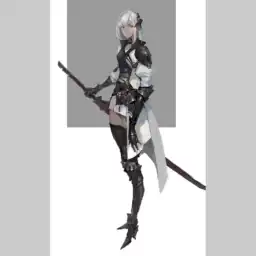
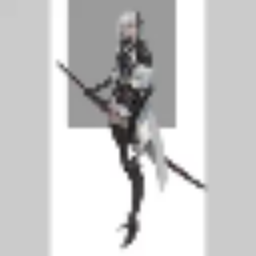
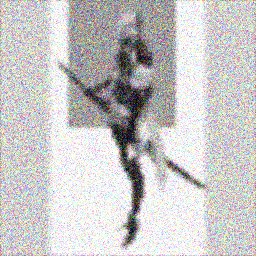

EDM Epoch 1 Loss: 0.4227:  14%|█▍        | 225/1602 [00:47<04:49,  4.76it/s]


KeyboardInterrupt: 

In [14]:
import time
from datetime import datetime
from tqdm import tqdm
import os
def train_some_sr(model_edm, optimizer_edm, paired_dataset):
    train_loader = DataLoader(paired_dataset, batch_size=8, shuffle=True)
    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    if resume:=False:
        load_checkpoint(model=model_edm, optimizer=optimizer_edm, path=good_weights)
    
    t0 = time.time()
    display_interval = 60
    next_display_time = time.time()
    checkpoint_interval = 60 * 60
    next_checkpoint_time = time.time() + checkpoint_interval
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    for epoch in range(999999):
        pbar = tqdm(train_loader)
        for x in pbar:
            hr,lr = x
            if not os.path.exists("/tmp/training_running.txt"):
                break
            loss = train_a_batch(model_edm,optimizer_edm,x)
            if time.time() > next_display_time:
                with torch.no_grad():
                    next_display_time = next_display_time + 30
                    lr_up = F.interpolate(lr, size=hr.shape[-2:], mode='bilinear', align_corners=False).cuda()
                    out = edm_ancestral_sampling(model, lr_up, num_steps=18,batch_size=8,img_shape=(3,256,256))
                    imgs = [hr[0],lr_up[0],out[0]]
                    dt = time.strftime('%H:%M:%S', time.gmtime(time.time() - t0))
                    title = f"SR training at {dt} loss {loss}"
                    h = html_for_images((sr_to_pil(i) for i in imgs), title=title)
                    ipd.clear_output(wait=True)
                    ipd.display(ipd.HTML(h))

            pbar.set_description(f"EDM Epoch {epoch+1} Loss: {loss:.4f}")



    del model_edm,optimizer_edm
    return path

#train_some(experiment_name)
train_some_sr(model, optimizer,paired_dataset)